# 1. Set up the notebook

Import modules.

In [170]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from IPython.display import display, IFrame, HTML

Define a function to load flight data from hardware experiments and resample it at 100 Hz using linear interpolation.

In [171]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [172]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. Define constants

Define the acceleration of gravity in $\text{kg}\cdot\text{m} \;/\; \text{s}^2$:

In [173]:
g = 9.81

Define the mass of the drone in $\text{kg}$:

In [174]:
m = 0.0312 

Method to calculate the moment of inertia for each axis:

In [175]:
def J_calc(r, T, m):
    return m*g*r*(2*np.pi/T)**(-2) - m*r**2

# 3. Estimate the moment of inertia about the $x$-axis

Define the distance in meters between the axis of rotation and the center of mass:

In [176]:
r_x = 0.030

Photo of the rig:

![x-axis-rig](x-rig.png)

Video of the drone swinging on your rig, while we were collecting data:

In [213]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_vpx52wn6')

Load and resample data.

The `load_hardware_data` function has two optional arguments:

* `t_min_offset` allows you to discard data at the *start* of the experiment - if its value is `4.`, for example, then the *first* four seconds of data will be discarded
* `t_max_offset` allows you to discard data at the *end* of the experiment - if its value is `4.`, for example, then the *last* four seconds of data will be discarded


In [178]:
data = load_hardware_data(
    'x_data.json',
    t_min_offset=0.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [179]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $x$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small.

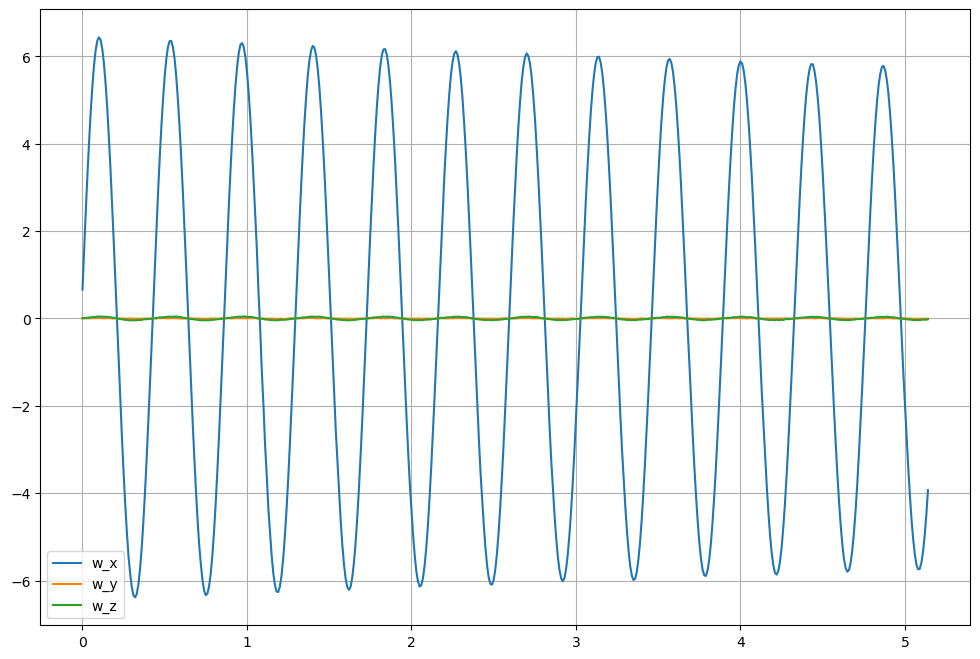

In [180]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

Calculate the mean peak-to-peak time:

* Find the index $i_k$ of each peak $k\in\{0, \dotsc, n-1\}$ in your data.
* Find the time $t_k$ at each peak for $k\in\{0, \dotsc, n-1\}$.
* Find the difference $T_k = t_{k+1} - t_k$ between consecutive peak times for $k \in \{0, \dotsc, n-2\}$.
* Find the mean difference: $$\widehat{T} = \dfrac{1}{n-1} \sum_{k=0}^{n-2} T_k.$$ This is an estimate of the oscillation period.


In [181]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_x, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_x_peaks = w_x[i_peaks]

# Find the difference between consecutive peak times
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T_x = np.mean(t_diff)

Print the peak times:

In [182]:
print(t_peaks)

[0.1  0.54 0.97 1.4  1.84 2.27 2.7  3.14 3.57 4.   4.43 4.87]


Plot the peaks:

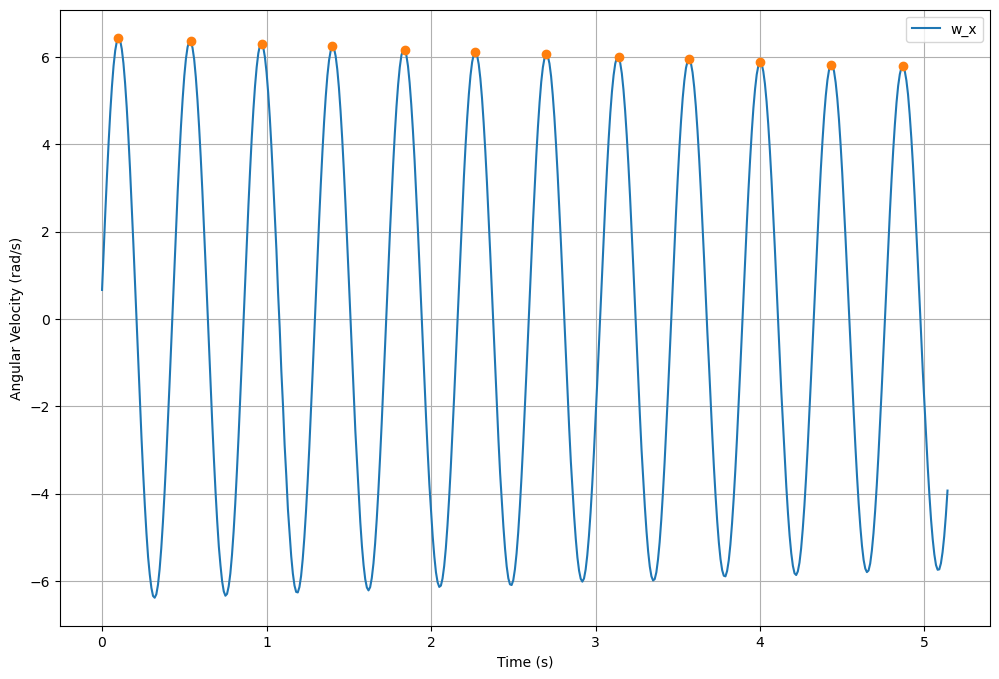

In [183]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t_peaks, w_x_peaks, '.', markersize=12)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period:

In [184]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T_x:.4f}')

time differences: [0.44 0.43 0.43 0.44 0.43 0.43 0.44 0.43 0.43 0.43 0.44]

period estimate (i.e., mean time difference): T = 0.4336


Compute the moment of inertia about the $x$ axis (see formula from theory).

In [185]:
J_x = J_calc(r_x, T_x, m)
print('J_x: ', J_x)

J_x:  1.5655742826394717e-05


# 4. Estimate the moment of inertia about the $y$-axis

Photo of the rig:

![y-axis-rig](y-rig.png)

Video of the drone swinging on your rig, while we were collecting data:

In [214]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_le3bx6ou')

In [186]:
r_y = 0.03

In [187]:
data = load_hardware_data(
    'y_data.json',
    t_min_offset=0.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [188]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $x$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

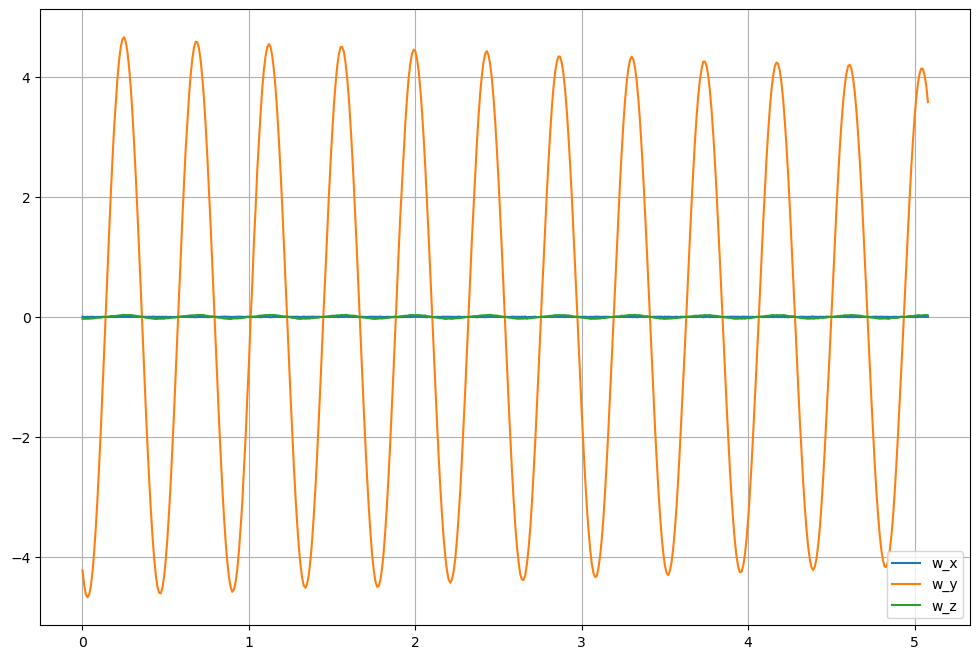

In [189]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

In [190]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_y, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_y_peaks = w_y[i_peaks]

# Find the difference between consecutive peak times
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T_y = np.mean(t_diff)

Sanity check - print the peak times:

In [191]:
print(t_peaks)

[0.25 0.68 1.12 1.56 1.99 2.43 2.86 3.3  3.74 4.17 4.61 5.04]


Sanity check - plot the peaks:

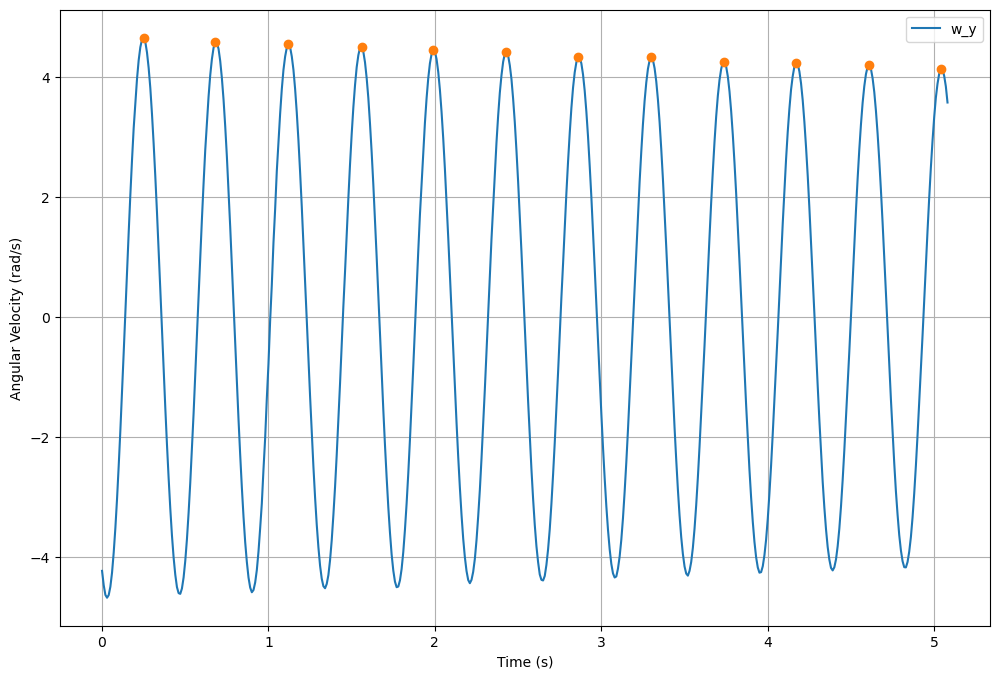

In [192]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_y, label='w_y')
plt.plot(t_peaks, w_y_peaks, '.', markersize=12)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [193]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T_y:.4f}')

time differences: [0.43 0.44 0.44 0.43 0.44 0.43 0.44 0.44 0.43 0.44 0.43]

period estimate (i.e., mean time difference): T = 0.4355


In [194]:
J_y = J_calc(r_y, T_y, m)
print('J_y: ', J_y)

J_y:  1.6023268461738194e-05


# 5. Estimate the moment of inertia about the $z$-axis

Add cells here to repeat the same process as above...

Photo of the rig:

![z-axis-rig](z-rig.png)

Video of the drone swinging on your rig, while we were collecting data:

In [215]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_tvbe1ogj')

In [195]:
r_z = 0.016 # m

In [196]:
data = load_hardware_data(
    'z_data.json',
    t_min_offset=0.,
    t_max_offset=0.
)

Parse data to get time and the three components of angular velocity (in radians / second).

In [197]:
t = data['time']
w_x = np.deg2rad(data['gyro.x'])
w_y = np.deg2rad(data['gyro.y'])
w_z = np.deg2rad(data['gyro.z'])

Plot all three components of angular velocity. You are trying to estimate the moment of inertia about the $x$ axis. The component of angular velocity about this axis should be large, and the components of angular velocity about the other two axes should be negligibly small. It is important to check this.

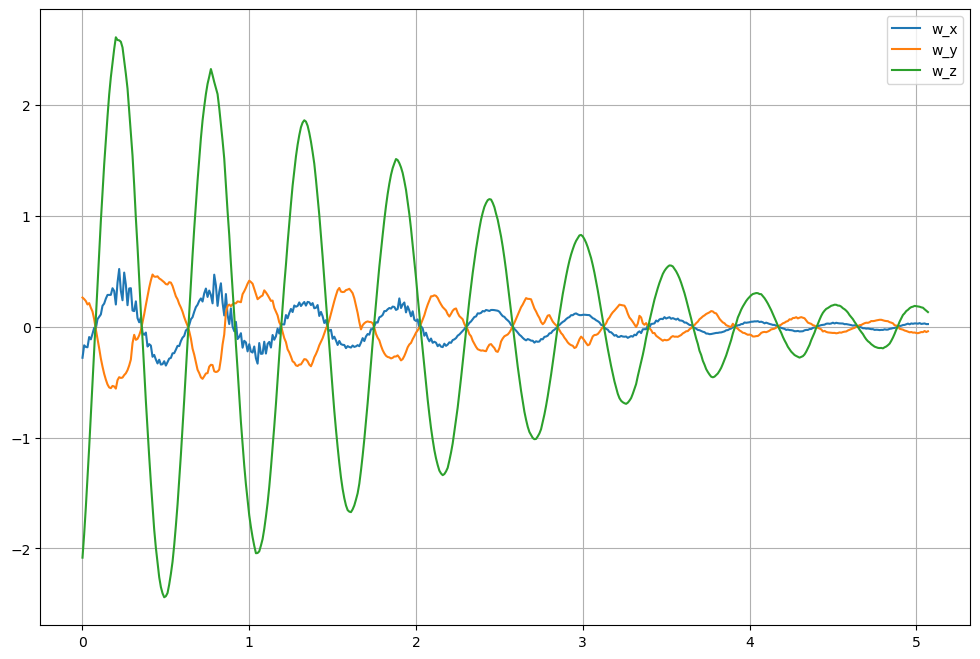

In [198]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_x, label='w_x')
plt.plot(t, w_y, label='w_y')
plt.plot(t, w_z, label='w_z')
plt.legend()
plt.grid()

In [199]:
# Find the index of each peak (increase "prominence" if you get bad results)
peaks = find_peaks(w_z, prominence=0)
i_peaks = peaks[0]

# Find the time at each peak
t_peaks = t[i_peaks]

# Find w_x at each peak (for visualization)
w_z_peaks = w_z[i_peaks]

# Find the difference between consecutive peak times
t_diff = t_peaks[1:] - t_peaks[:-1]

# Find the mean difference as an estimate of the oscillation period
T_z = np.mean(t_diff)

Sanity check - print the peak times:

In [200]:
print(t_peaks)

[0.2  0.77 1.33 1.88 2.44 2.99 3.52 4.04 4.51 4.79 4.99]


Sanity check - plot the peaks:

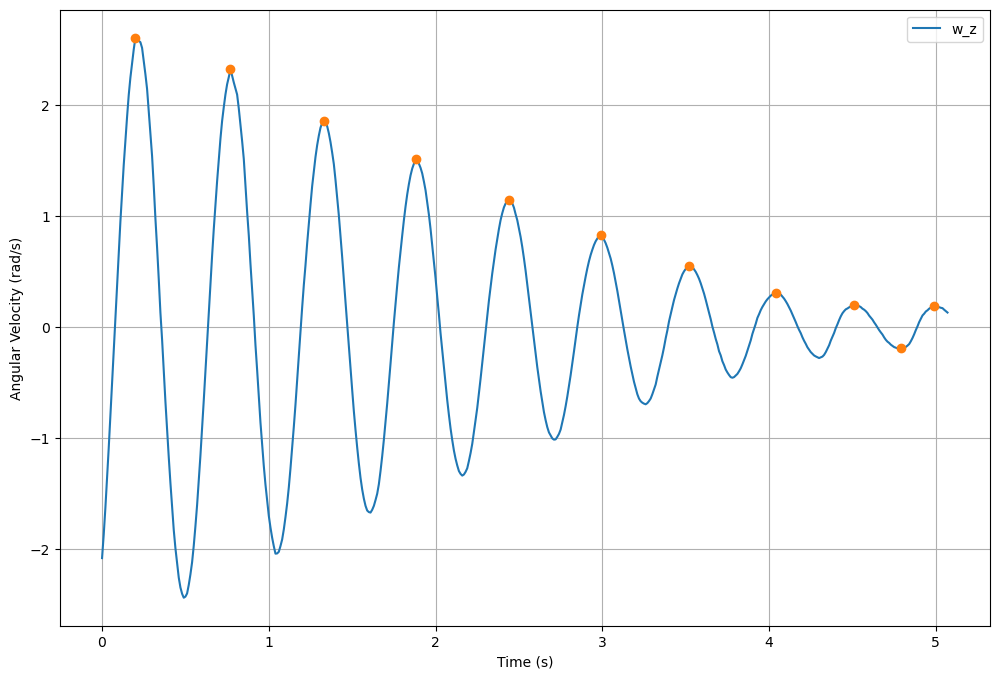

In [201]:
plt.figure(figsize=(12, 8))
plt.plot(t, w_z, label='w_z')
plt.plot(t_peaks, w_z_peaks, '.', markersize=12)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid()

Sanity check - print the difference between consecutive peak times, as well as the resulting estimate of the oscillation period (you may also want to look at a histogram of the time differences, or to compute their variance):

In [202]:
print(f'time differences: {t_diff}\n')
print(f'period estimate (i.e., mean time difference): T = {T_z:.4f}')

time differences: [0.57 0.56 0.55 0.56 0.55 0.53 0.52 0.47 0.28 0.2 ]

period estimate (i.e., mean time difference): T = 0.4790


In [203]:
J_z = J_calc(r_z, T_z, m)
print('J_z: ', J_z)

J_z:  2.0474109247308385e-05


# 6. Summarize and discuss the results

### Summary of results

In [204]:
print(f'm = {m:.2} kg')
print(f'J_x = {J_x:.2e} kg m^2')
print(f'J_y = {J_y:.2e} kg m^2')
print(f'J_z = {J_z:.2e} kg m^2')

m = 0.031 kg
J_x = 1.57e-05 kg m^2
J_y = 1.60e-05 kg m^2
J_z = 2.05e-05 kg m^2


### Sources of error

**Uncertainty**
* r = $\pm 0.0001$ m
* m = $\pm 0.0001$ kg
* J $\approxeq \pm 0.001$ kg m$^2$

**Assumptions**
* We assume that the center of mass is at the center of the drone. This is not necessarily true since the components aren't perfectly symmetrical (ex. battery)
* In calculating the moments of inertia, we assume the drone is rotating perfectly in each axis. This is not true since there was also motion in the other axes. This is shown the clearest through the $w_z$ graph

* The experiment could be made better by creating more rigid rigs to reduce rotational capability in axes you aren't actively testing. This would especially improve the $J_z$ data.
* The analysis could be made more complete by also calculating the coupled rotation moments to complete the moment of inertia matrix for the drone.

### Analysis of sensitivity

$\frac{\partial J}{\partial m} = gr(\frac{2 \pi}{T})^{-2} - r^2\\$
If you overestimate the mass, you will have overestimated $J$

In [210]:
Jm = g*r_x*(2*np.pi/T_x)**(-2) - r_x**2
Jm

0.0005017866290511128

$\frac{\partial J}{\partial r} = mg(\frac{2 \pi}{T})^{-2} - 2mr\\$
If you overestimate the distance between the axis of rotation and center of mass, you will have overestimated $J$

In [211]:
Jr = m*g*(2*np.pi*T_x)**(-2) - 2*m*r_x
Jr

0.03935791855645973

$\frac{\partial J}{\partial T} = \frac{mgrT}{4\pi^2}$

If you overestimate the period, you will have overestimated $J$

In [212]:
JT = m*g*r_x*T_x / (4*np.pi**2)
JT

0.00010085810714682218